# Import Lib

In [1]:
import numpy as np
import pandas
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) 数据

In [3]:
X, y = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto", cache=True, return_X_y=True)
X = X.astype(np.float32) / 255.0
y = y.astype(str)
# 先分成训练集和临时集，后面要换成test和valid
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=20000, stratify=y, random_state=42)
# 分成test和valid
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

# 2) 基线：SGDClassifier

In [4]:
sgd = SGDClassifier(
    # 损失类型
    loss="log_loss",
    # 正则化惩罚
    penalty="l2",
    # 正则化强度
    alpha=1e-4,
    # 启用早停
    early_stopping=True,
    # 早停判定条件
    n_iter_no_change=3,
    # 固定随机数种子
    random_state=42)
# 用训练集训练数据
sgd.fit(X_train, y_train)
# 用训练好的模型在验证集
pred_valid_sgd = sgd.predict(X_valid)
# 用 sklearn 的 accuracy_score() 计算验证集准确率
print("SGD valid acc:", accuracy_score(y_valid, pred_valid_sgd))

SGD valid acc: 0.8876


# 3) Logistic 回归 + 超参扫描

In [5]:
param_grid = {
    #正则化强度空间，可以多加一点
    "C": np.logspace(-3, 1, 5),          # 0.001~10
    # 类型
    "penalty": ["l2", "l1"],
    # 优化器
    "solver": ["lbfgs", "saga"],         # lbfgs不支持L1，会被自动跳过警告；也可分两次扫更干净
    # 最大迭代次数
    "max_iter": [100]
}
# 指定多分类方式为 softmax（多项式逻辑回归），比 one-vs-rest 效果更好
logreg = LogisticRegression(multi_class="multinomial", n_jobs=-1)
# 交叉验证 (cross-validation) 的作用是防止模型过拟合，将训练集分成 3 份（folds）；每次用 2 份训练、1 份验证；重复 3 次；
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 定义网格搜索器
grid = GridSearchCV(
    # 模型
    logreg,
    # 参数网格
    param_grid,
    # 评估指标
    scoring="accuracy",
    # 交叉验证方案
    cv=cv,
    # 并行计算
    n_jobs=-1,
    # 显示进度
    verbose=1)

# 开始搜索并训练
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best cv acc:", grid.best_score_)

# 拿出最优模型再验证
best = grid.best_estimator_
pred_valid = best.predict(X_valid)
print("Valid acc:", accuracy_score(y_valid, pred_valid))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\PythonFile\M1_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "D:\PythonFile\M1_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\PythonFile\M1_Project\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\PythonFile\M1_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py", line 121

Best params: {'C': np.float64(1.0), 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best cv acc: 0.9207400707380068
Valid acc: 0.919


D:\PythonFile\M1_Project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# 4) 测试集评估

Test acc: 0.9226
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       986
           1       0.95      0.98      0.96      1125
           2       0.91      0.91      0.91       998
           3       0.90      0.90      0.90      1020
           4       0.92      0.92      0.92       975
           5       0.89      0.88      0.89       902
           6       0.94      0.95      0.94       983
           7       0.94      0.95      0.94      1042
           8       0.90      0.87      0.89       975
           9       0.91      0.88      0.90       994

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



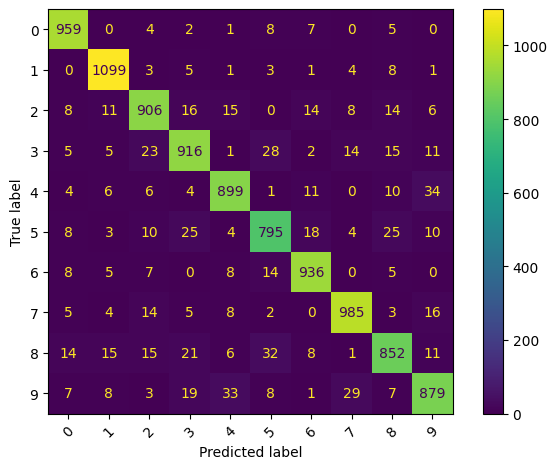

In [6]:
pred_test = best.predict(X_test)
print("Test acc:", accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

# 混淆矩阵
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, values_format='d', xticks_rotation=45)
plt.tight_layout(); plt.show()

# 5) 错误样本可视化

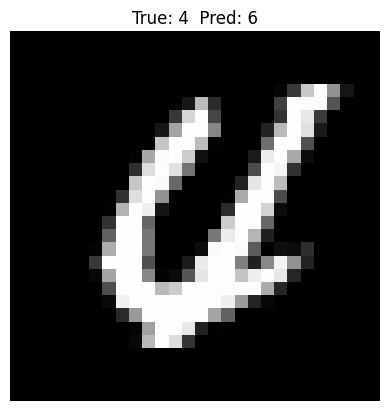

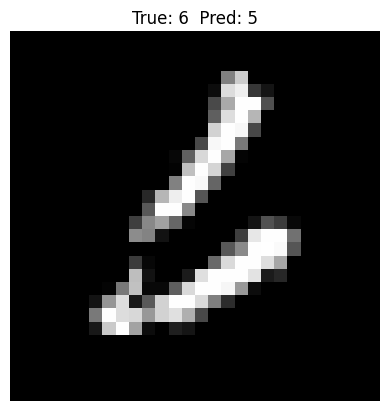

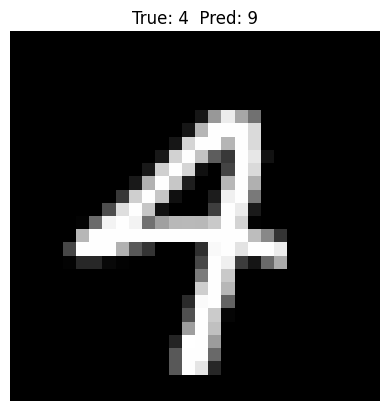

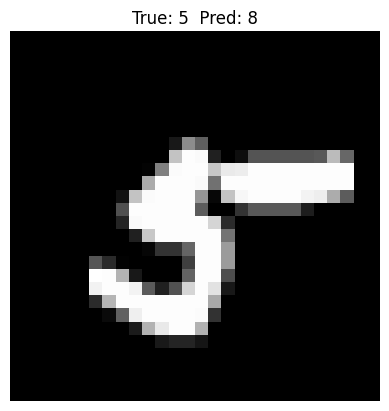

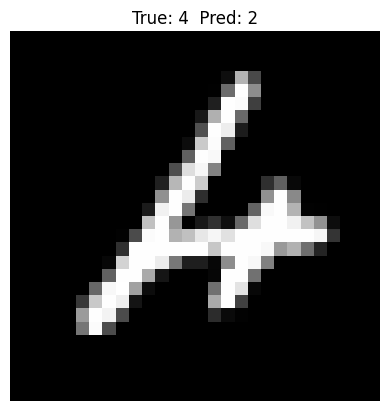

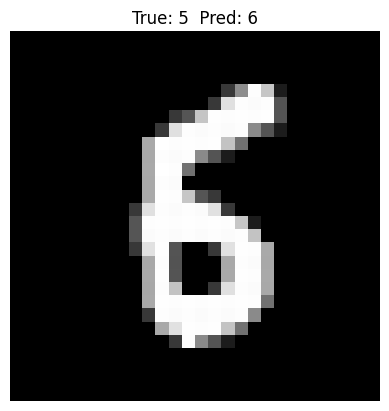

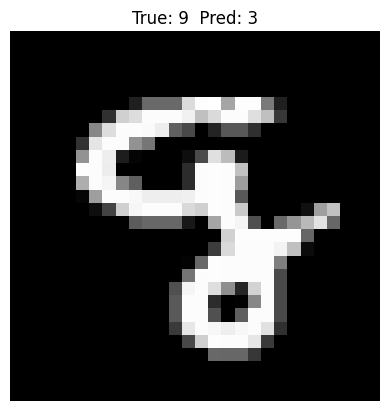

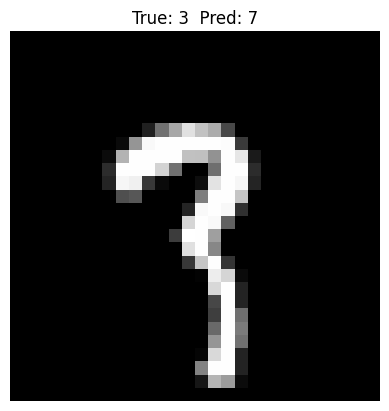

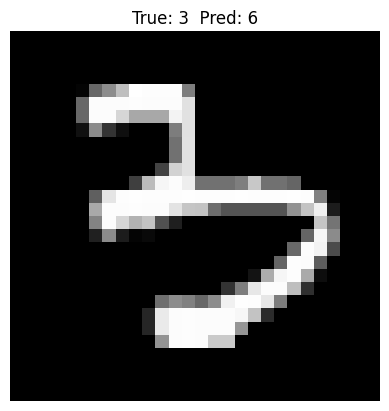

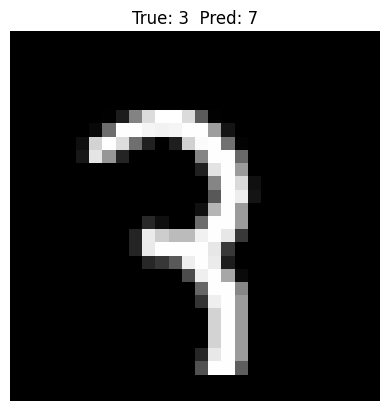

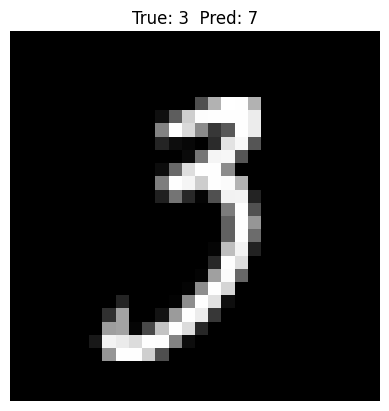

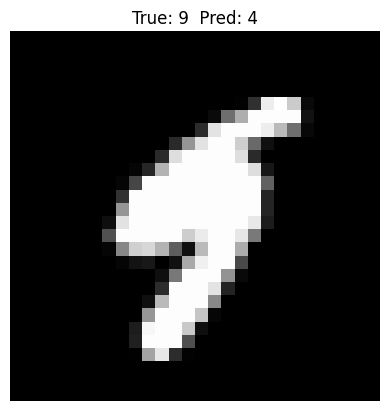

In [7]:
wrong = np.where(pred_test != y_test)[0]
for i in wrong[:12]:
    plt.figure()
    plt.imshow(X_test[i].reshape(28,28), cmap="gray")
    plt.title(f"True: {y_test[i]}  Pred: {pred_test[i]}")
    plt.axis('off')
    plt.show()

# 6) 权重可视化（每一类的权重图：28x28）

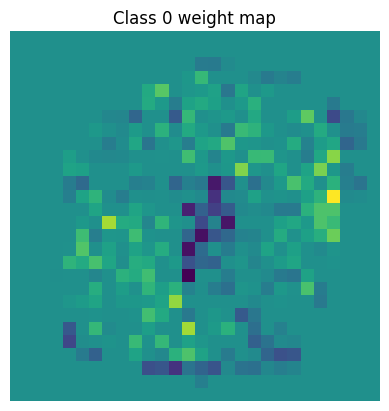

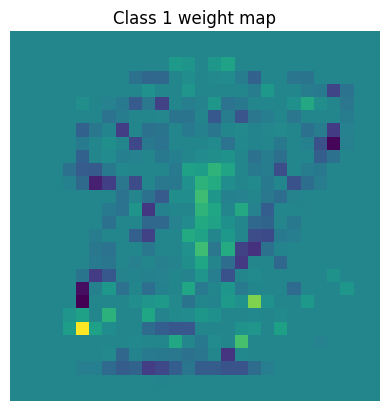

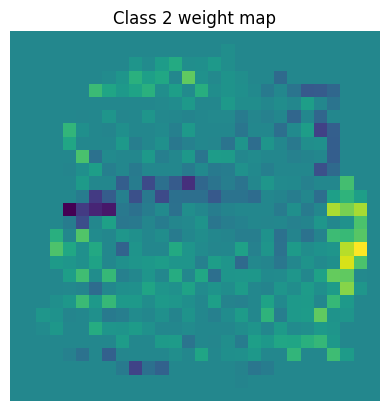

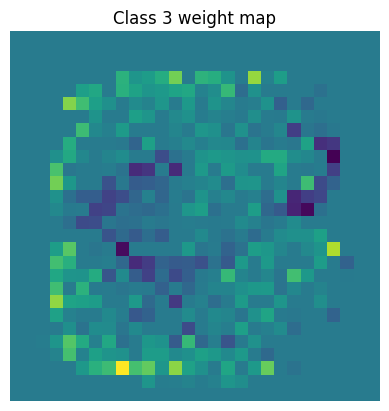

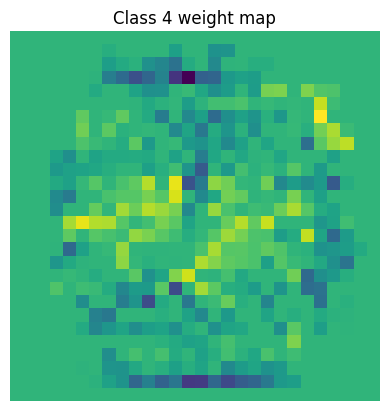

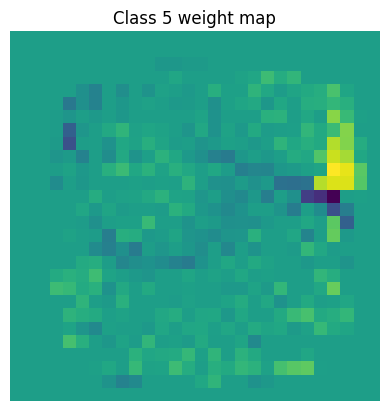

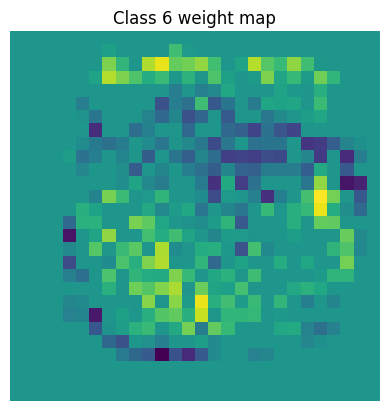

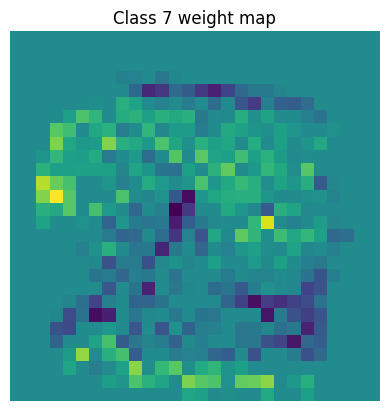

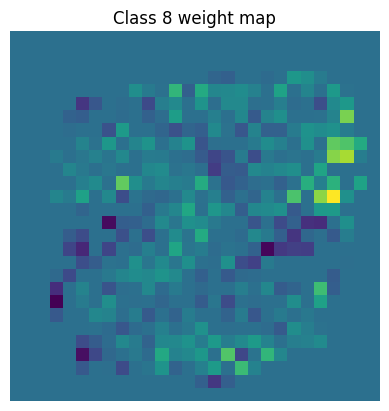

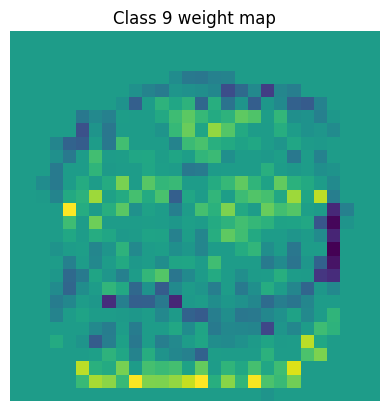

In [8]:
W = best.coef_  # shape: (10, 784)
for k in range(W.shape[0]):
    plt.figure()
    plt.imshow(W[k].reshape(28,28))
    plt.title(f"Class {best.classes_[k]} weight map")
    plt.axis('off')
    plt.show()